In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import itertools
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#Read the dataset which is the output of TOPSIS
step10=pd.read_csv('../data/football_step10.csv',index_col=0)

In [3]:
#Drop unnecessary Date column
step10.drop("Date",axis=1,inplace=True)

In [4]:
#Chech the dataframe
step10.head()

,Year,Month,Week_ofday,League_ID,League,team1,team2,spi_1,spi_2,prob_1,...,DETAIL_spi_y,OVRL_spi_y,Avg_Age_y,Total_marketcap_y,Value_per_year_y,point_team1,point_team2,rolling5_team1,rolling5_team2,scor_diff
0,2022,10,0,1854,Serie A,Verona,Roma,58.27,73.95,0.2429,...,0.618281,0.367339,26.00,365000000.0,0.129278,0.0,4.0,3.0,13.5,-2
1,2022,10,0,1854,Serie A,Monza,Bologna,52.43,54.39,0.3983,...,0.320189,0.339007,25.50,125000000.0,0.038690,0.0,4.0,6.0,1.5,-1
2,2022,10,0,1869,LaLiga,Elche,Getafe,52.69,62.53,0.3575,...,0.112096,0.208027,27.80,137000000.0,0.618056,0.0,4.0,2.0,7.0,-1
3,2022,10,6,1869,LaLiga,Osasuna,Real Valladolid,67.77,58.91,0.5122,...,0.235717,0.280795,28.30,59000000.0,0.603175,3.0,0.0,9.0,5.5,2
4,2022,10,6,1843,Ligue 1,Auxerre,AC Ajaccio,46.20,52.39,0.3827,...,0.255741,0.268034,25.55,50000000.0,0.320000,3.0,0.0,5.0,9.5,1


# Win-Lose Profit Calculator

In [6]:
#Function to Calculate the profit/loss in the situtation where $100 staked to all the matches
def calculate_value_winlose(row):
    if row['True_False'] == 1:
        if row['scor_diff'] == 0:
            return 100 * (row['odds_0'] - 1)
        elif row['scor_diff'] == 1:
            return 100 * (row['odds_1'] - 1)
        elif row['scor_diff'] == 2:
            return 100 * (row['odds_2'] - 1)
    elif row['True_False'] == 0:
        return -100

# Draw No Bet Profit Calculator

In [7]:
#Function to Calculate the profit/loss in the situtation where $100 staked to 
#all the matches that are predicted 1 or 2 as the result.
def calculate_value_dnb(row):
    if row['True_False'] == 1:
        if row['scor_diff'] < 0:
            return 100 * (row['dnb_odds_2'] - 1)
        
        elif row['scor_diff'] > 0:
            return 100 * (row['dnb_odds_1'] - 1)
        
    elif row['True_False'] == 0:
        return -100
    
    elif row['True_False']==2:
        return 0

# Derive the Odds and Draw no bet Odds from probabilities

In [8]:
# ADD BETTING ODD COLUMNS TO Calculate potential profits

# Calculating the betting odds

def probability_to_reg_dnb_odds(df):
    # Calculate the regular odds for team1, team2, and draw
    
    df1=df.copy()
    odds_1 = 1 / df1['prob_1'] 
    odds_2 = 1 / df1['prob_2']
    odds_0 = 1 / df1['prob_0']
    
    df1['odds_1'] = odds_1
    df1['odds_2'] = odds_2
    df1['odds_0'] = odds_0
    
    # Calculate the "Draw No Bet" odds for team1 and team2
    df1['dnb_odds_1'] = odds_1 * (1 - df1['prob_0']) # team1-odd
    df1['dnb_odds_2'] = odds_2 * (1 - df1['prob_0']) # team2-odd
    
    df1.drop(['prob_1','prob_2','prob_0'],axis=1, inplace=True)

    return df1

# MODEL A: DRAW NO BET Profits by Score Difference Prediction

In [55]:

def train_model_draw_no_bet(df):
    #copy the df just in case
    df_processed = df.copy()
    
    #Drop unnecessary columns
    df_processed.drop(['League', 'team1', 'team2','point_team1', 'point_team2','spi_1','spi_2'], axis=1, inplace=True)
    
    #Alter extreme values to be able to predict with the classification models
    df_processed.loc[df_processed['scor_diff'] == 9, 'scor_diff'] = 8
    df_processed.loc[df_processed['scor_diff'] == -9, 'scor_diff'] = -8
    
    #Define feature and target columns
    X = df_processed.drop(['scor_diff'], axis=1)
    y = df_processed['scor_diff']

    # Sort the DataFrame by date columns in descending order
    df_sorted = df_processed.sort_values(by=['Year', 'Month', 'Week_ofday'], ascending=True)
    

    # Calculate the indices for the train-test split
    train_size = int(0.75 * len(df_sorted))
    train_indices = df_sorted.index[:train_size]
    test_indices = df_sorted.index[train_size:]

    # Split the data into training and test sets
    X_train = X.loc[train_indices]
    X_test = X.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]

    # Create a list of all possible combinations of hyperparameters
    scaling = [MinMaxScaler(), StandardScaler(), RobustScaler()]
    classifier = [
        KNeighborsClassifier(3),
        KNeighborsClassifier(5),
        KNeighborsClassifier(7),
        GaussianNB(),
        GaussianNB(var_smoothing=0.1),
        GaussianNB(var_smoothing=0.01),
        RandomForestClassifier(max_depth=5, n_estimators=300),
        RandomForestClassifier(max_depth=10, n_estimators=500),
        RandomForestClassifier(max_depth=20, n_estimators=1000),
        AdaBoostClassifier(learning_rate=0.1),
        AdaBoostClassifier(learning_rate=0.01, n_estimators=100),
        AdaBoostClassifier(learning_rate=0.1, n_estimators=500),
        MLPClassifier(hidden_layer_sizes=(10, 5), learning_rate_init=0.01),
        MLPClassifier(hidden_layer_sizes=(20, 10), learning_rate_init=0.001),
        MLPClassifier(hidden_layer_sizes=(50, 25), learning_rate_init=0.0001),
        LogisticRegression(),
        LogisticRegression(C=0.1),
        LogisticRegression(C=0.01) 
        
    ]
    
    #Save the combination of scalers and classifiers
    combinations = list(itertools.product(scaling, classifier))

    # Initialize empty lists to store sums of profit and classification reports
    profit_sums = []
    classification_reports = []
    results = []

    #Put the pipeline in  for loop to see all the profits made by all combination
    for i, combo in enumerate(combinations):
        # Create a pipeline
        pipe = Pipeline([
            ('scaling', combo[0]),
            ('classifier', combo[1])
        ])

        # Fit the model
        pipe.fit(X_train, y_train)
        
        # Make predictions on test set
        y_pred = pipe.predict(X_test)
        
        # Calculate classification report
        clas_report = classification_report(y_test, y_pred)
        classification_reports.append(clas_report)
        
        df_result = df.loc[y_test.index].copy()
        df_result['y_prediction'] = y_pred

        df_result_step2 = df_result.copy()
        
        df_result_step2['True_False'] = 0  # Initialize with 0 (incorrect prediction)
    
        # LOST BET
        df_result_step2.loc[((df_result_step2['scor_diff'] < 0) & (df_result_step2['y_prediction'] > 0)) |
                            ((df_result_step2['scor_diff'] > 0) & (df_result_step2['y_prediction'] < 0)), 'True_False'] = 0

        # WON BET
        df_result_step2.loc[((df_result_step2['scor_diff'] < 0) & (df_result_step2['y_prediction'] < 0)) |
                            ((df_result_step2['scor_diff'] > 0) & (df_result_step2['y_prediction'] > 0)), 'True_False'] = 1

        # NO BET
        df_result_step2.loc[((df_result_step2['scor_diff'] == 0) & (df_result_step2['y_prediction'] == 0)) |
                            ((df_result_step2['scor_diff'] == 0) & (df_result_step2['y_prediction'] != 0)) |
                            ((df_result_step2['scor_diff'] != 0) & (df_result_step2['y_prediction'] == 0)), 'True_False'] = 2
        df_result_step2['True_False'] = df_result_step2['True_False'].astype(int)

        ########################################
        df_result_step2 = probability_to_reg_dnb_odds(df_result_step2)
        df_result_step2['profit'] = df_result_step2.apply(calculate_value_dnb, axis=1)

        
        # Calculate the sum of 'profit' column
        profit_sum = df_result_step2['profit'].sum()
        investment_total = (df_result_step2.True_False.value_counts().get(0, 0) + df_result_step2.True_False.value_counts().get(1, 0)) * 100
        profit_ratio = profit_sum / investment_total
        
        results.append({
            'combination': i + 1,
            'scaler': combo[0].__class__.__name__,
            'classifier': combo[1].__class__.__name__,
            'profit_sum': profit_sum,
            'profit_ratio': profit_ratio,
            'investment_total': investment_total
        })
        
        print(f"Combination {i+1}: {combo} - Profit Sum: {profit_sum} - Profit ratio:\
        {profit_sum/((df_result_step2.True_False.value_counts().get(0, 0) + df_result_step2.True_False.value_counts().get(1, 0))*100)}")
        print(f"Classification Report for Combination {i+1}:\n{clas_report}\n")
        print(df_result_step2.True_False.value_counts()) 
        
    return results, classification_reports

In [56]:
results_a ,classification_reports_a = train_model_draw_no_bet(step10)

Combination 1: (MinMaxScaler(), KNeighborsClassifier(n_neighbors=3)) - Profit Sum: -1215.4610032597707 - Profit ratio:        -0.014333266547874654
Classification Report for Combination 1:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.02      0.05      0.03        19
          -3       0.10      0.19      0.13        68
          -2       0.06      0.14      0.09       116
          -1       0.19      0.28      0.23       274
           0       0.28      0.32      0.30       401
           1       0.25      0.11      0.16       348
           2       0.21      0.09      0.13       174
           3       0.11      0.03      0.05        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2


Combination 8: (MinMaxScaler(), RandomForestClassifier(max_depth=10, n_estimators=500)) - Profit Sum: 3175.945452738582 - Profit ratio:        0.09259316188742221
Classification Report for Combination 8:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.09      0.03      0.04       116
          -1       0.26      0.18      0.22       274
           0       0.26      0.74      0.39       401
           1       0.30      0.11      0.16       348
           2       0.20      0.09      0.12       174
           3       0.20      0.02      0.04        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      

Combination 15: (MinMaxScaler(), MLPClassifier(hidden_layer_sizes=(50, 25), learning_rate_init=0.0001)) - Profit Sum: 481.67779137990374 - Profit ratio:        0.022508308008406717
Classification Report for Combination 15:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.00      0.00      0.00       116
          -1       0.30      0.14      0.19       274
           0       0.27      0.89      0.41       401
           1       0.31      0.04      0.07       348
           2       0.19      0.09      0.12       174
           3       0.00      0.00      0.00        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0

Combination 24: (StandardScaler(), GaussianNB(var_smoothing=0.01)) - Profit Sum: 3424.9432153415564 - Profit ratio:        0.05445060755709947
Classification Report for Combination 24:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.03      0.14      0.05         7
          -4       0.04      0.16      0.06        19
          -3       0.00      0.00      0.00        68
          -2       0.10      0.09      0.09       116
          -1       0.22      0.18      0.20       274
           0       0.28      0.54      0.37       401
           1       0.27      0.05      0.08       348
           2       0.24      0.13      0.17       174
           3       0.17      0.11      0.14        87
           4       0.12      0.03      0.05        68
           5       0.04      0.20      0.06        10
           6       0.00      0.00      0.00         2
    

Combination 31: (StandardScaler(), MLPClassifier(hidden_layer_sizes=(10, 5), learning_rate_init=0.01)) - Profit Sum: 550.9122614618768 - Profit ratio:        0.018363742048729228
Classification Report for Combination 31:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.19      0.04      0.07       116
          -1       0.31      0.12      0.17       274
           0       0.27      0.82      0.41       401
           1       0.26      0.13      0.17       348
           2       0.17      0.07      0.10       174
           3       0.00      0.00      0.00        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.0

Combination 38: (RobustScaler(), KNeighborsClassifier()) - Profit Sum: 3442.4610556341113 - Profit ratio:        0.04476542335024852
Classification Report for Combination 38:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.11      0.11      0.11        19
          -3       0.04      0.04      0.04        68
          -2       0.11      0.14      0.12       116
          -1       0.21      0.28      0.24       274
           0       0.28      0.39      0.32       401
           1       0.25      0.17      0.20       348
           2       0.21      0.13      0.16       174
           3       0.06      0.02      0.03        87
           4       0.08      0.01      0.03        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           8  

Combination 45: (RobustScaler(), RandomForestClassifier(max_depth=20, n_estimators=1000)) - Profit Sum: 2130.312145730942 - Profit ratio:        0.04193527845927052
Classification Report for Combination 45:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.25      0.05      0.09        19
          -3       0.14      0.01      0.03        68
          -2       0.09      0.04      0.06       116
          -1       0.25      0.22      0.23       274
           0       0.26      0.60      0.37       401
           1       0.27      0.17      0.21       348
           2       0.19      0.11      0.14       174
           3       0.08      0.02      0.04        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00   

Combination 52: (RobustScaler(), LogisticRegression()) - Profit Sum: -530.2900498108388 - Profit ratio:        -0.016942174115362262
Classification Report for Combination 52:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.10      0.07      0.08       116
          -1       0.19      0.08      0.12       274
           0       0.27      0.80      0.41       401
           1       0.25      0.07      0.12       348
           2       0.17      0.09      0.12       174
           3       0.00      0.00      0.00        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           8  

In [53]:
results_a

[{'combination': 1,
  'scaler': 'MinMaxScaler',
  'classifier': 'KNeighborsClassifier',
  'profit_sum': -1215.4610032597707,
  'profit_ratio': -0.014333266547874654,
  'investment_total': 84800},
 {'combination': 2,
  'scaler': 'MinMaxScaler',
  'classifier': 'KNeighborsClassifier',
  'profit_sum': -3528.3250786433846,
  'profit_ratio': -0.044605879628867064,
  'investment_total': 79100},
 {'combination': 3,
  'scaler': 'MinMaxScaler',
  'classifier': 'KNeighborsClassifier',
  'profit_sum': -213.73970309154947,
  'profit_ratio': -0.002842283285791881,
  'investment_total': 75200},
 {'combination': 4,
  'scaler': 'MinMaxScaler',
  'classifier': 'GaussianNB',
  'profit_sum': 3325.0590676731263,
  'profit_ratio': 0.0528626242873311,
  'investment_total': 62900},
 {'combination': 5,
  'scaler': 'MinMaxScaler',
  'classifier': 'GaussianNB',
  'profit_sum': 2946.8743473509358,
  'profit_ratio': 0.05407108894221901,
  'investment_total': 54500},
 {'combination': 6,
  'scaler': 'MinMaxScaler',

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


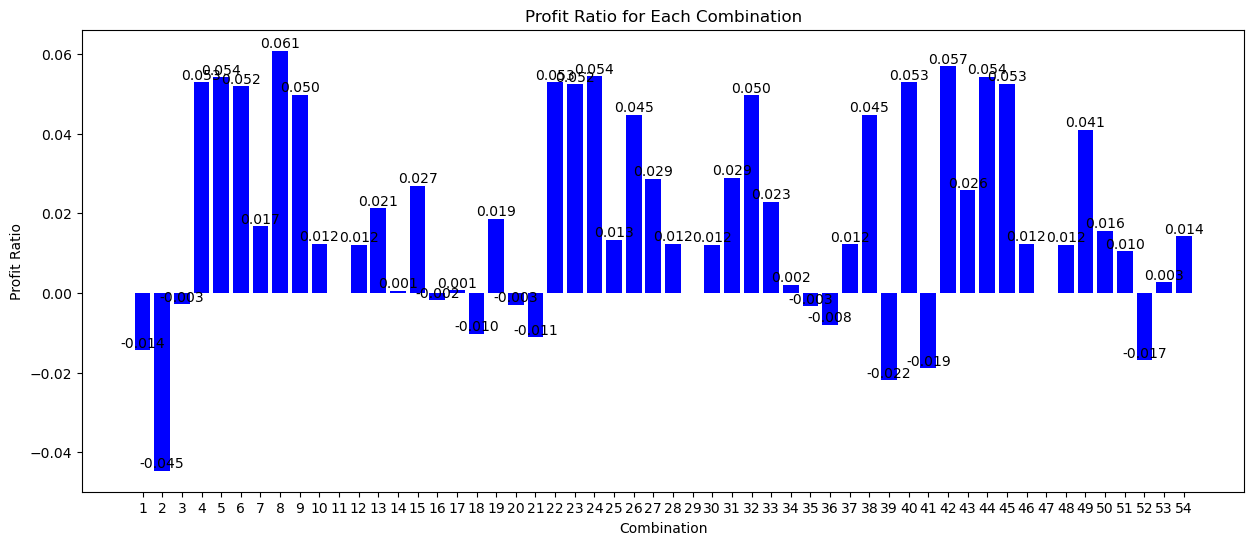

In [54]:
results_viz = pd.DataFrame(results_a)

plt.figure(figsize=(15, 6))
plt.bar(results_viz['combination'], results_viz['profit_ratio'], color='b')
plt.xlabel('Combination')
plt.ylabel('Profit Ratio')
plt.title('Profit Ratio for Each Combination')
plt.xticks(results_viz['combination'])

for index, value in enumerate(results_viz['profit_ratio']):
    plt.text(results_viz['combination'][index], value, f'{value:.3f}', horizontalalignment='center', verticalalignment='bottom')

plt.show()



In [49]:
# Sort the results list by profit_ratio in descending order
sorted_results = sorted(results_a, key=lambda x: x['profit_ratio'], reverse=True)

# Filter the top 10 models
top_10_models = sorted_results[:10]

# Print the top 10 models
for model in top_10_models:
    print(model)

{'combination': 12, 'scaler': 'MinMaxScaler', 'classifier': 'AdaBoostClassifier', 'profit_sum': 0, 'profit_ratio': nan, 'investment_total': 0}
{'combination': 29, 'scaler': 'StandardScaler', 'classifier': 'RandomForestClassifier', 'profit_sum': 3773.2489024236716, 'profit_ratio': 0.10842669259838136, 'investment_total': 34800}
{'combination': 26, 'scaler': 'StandardScaler', 'classifier': 'MLPClassifier', 'profit_sum': 3364.9434539618915, 'profit_ratio': 0.08167338480490027, 'investment_total': 41200}
{'combination': 10, 'scaler': 'MinMaxScaler', 'classifier': 'RandomForestClassifier', 'profit_sum': 2814.353708510015, 'profit_ratio': 0.07995323035539816, 'investment_total': 35200}
{'combination': 31, 'scaler': 'StandardScaler', 'classifier': 'AdaBoostClassifier', 'profit_sum': 0, 'profit_ratio': nan, 'investment_total': 0}
{'combination': 49, 'scaler': 'RobustScaler', 'classifier': 'RandomForestClassifier', 'profit_sum': 3706.15189435701, 'profit_ratio': 0.07579042728746442, 'investment

In [24]:
max(profit_sums_a)

3442.4610556341113

In [28]:
print(max(classification_reports_a))

              precision    recall  f1-score   support

          -8       0.00      0.00      0.00         0
          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.15      0.06      0.09       116
          -1       0.28      0.15      0.19       274
           0       0.27      0.74      0.40       401
           1       0.23      0.03      0.05       348
           2       0.17      0.11      0.13       174
           3       0.14      0.01      0.02        87
           4       0.00      0.00      0.00        68
           5       0.07      0.10      0.08        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1

    accuracy              

# MODEL B: 1 - 0 - 2 - WINNER PREDICTION - By Result Prediction

In [14]:
def train_model_102(df):
    #copy the df just in case
    df_processed = df.copy()
    
    #Drop unnecessary columns
    df_processed.drop(['League', 'team1', 'team2','point_team1', 'point_team2','spi_1','spi_2'], axis=1, inplace=True)
    
    #Alter values to be able to make classification models predict the result rather than score difference
    df_processed.loc[df_processed['scor_diff'] == 0 , 'scor_diff'] = 0
    df_processed.loc[df_processed['scor_diff'] > 0 , 'scor_diff'] = 1
    df_processed.loc[df_processed['scor_diff'] < 0, 'scor_diff'] = 2

    #Define feature and target columns
    X = df_processed.drop(['scor_diff'], axis=1)
    y = df_processed['scor_diff']

    # Sort the DataFrame by date columns in descending order
    df_sorted = df_processed.sort_values(by=['Year', 'Month', 'Week_ofday'], ascending=True)
    
    # Calculate the indices for the train-test split
    train_size = int(0.75 * len(df_sorted))
    train_indices = df_sorted.index[:train_size]
    test_indices = df_sorted.index[train_size:]

    # Split the data into training and test sets
    X_train = X.loc[train_indices]
    X_test = X.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]
    
    # Create a list of all possible combinations of hyperparameters
    scaling = [MinMaxScaler(), StandardScaler(),RobustScaler()]
    classifier = [
        KNeighborsClassifier(3),
        DecisionTreeClassifier(max_depth=5),
        GaussianNB(),
        RandomForestClassifier(max_depth=5, n_estimators=300),
        AdaBoostClassifier(learning_rate=0.1),
        LogisticRegression(),
        MLPClassifier(hidden_layer_sizes=(10, 5), learning_rate_init=0.01),
        MLPClassifier(hidden_layer_sizes=(20, 10), learning_rate_init=0.001),
        MLPClassifier(hidden_layer_sizes=(50, 25), learning_rate_init=0.0001),
        RandomForestClassifier(max_depth=10, n_estimators=500),
        RandomForestClassifier(max_depth=20, n_estimators=1000),
        AdaBoostClassifier(learning_rate=0.01, n_estimators=100),
        AdaBoostClassifier(learning_rate=0.1, n_estimators=500),
        KNeighborsClassifier(5),
        KNeighborsClassifier(7),
        GaussianNB(var_smoothing=0.1),
        GaussianNB(var_smoothing=0.01),
        LogisticRegression(C=0.1),
        LogisticRegression(C=0.01)
    ]
    #Save the combination of scalers and classifiers
    combinations = list(itertools.product( scaling, classifier))
    # Initialize empty lists to store sums of profit and classification reports
    profit_sums = []
    classification_reports = []
    
    
    #Put the pipeline in  for loop to see all the profits made by all combination
    for i, combo in enumerate(combinations):
        # Create a pipeline
        pipe = Pipeline([
            ('scaling', combo[0]),
            ('classifier', combo[1])
        ])

        # Fit the model
        pipe.fit(X_train, y_train)
        
        # Make predictions on test set
        y_pred = pipe.predict(X_test)
        
        # Calculate classification report
        clas_report = classification_report(y_test, y_pred)
        classification_reports.append(clas_report)
        
        df_result = df.loc[y_test.index].copy()
        df_result['y_prediction'] = y_pred

        df_result_step2 = df_result.copy()
        
        df_result_step2['True_False'] = 0  # Initialize with 0 (incorrect prediction)
        
        ########################################
        # LOST BET
        df_result_step2.loc[((df_result_step2['scor_diff'] == 1) & (df_result_step2['y_prediction'] != 1)) |
                            ((df_result_step2['scor_diff'] == 0) & (df_result_step2['y_prediction'] != 0)) |
                            ((df_result_step2['scor_diff'] == 2) & (df_result_step2['y_prediction'] != 2)), 'True_False'] = 0
        
        # WON BET
        df_result_step2.loc[((df_result_step2['scor_diff'] == 1) & (df_result_step2['y_prediction'] == 1)) |
                            ((df_result_step2['scor_diff'] == 0) & (df_result_step2['y_prediction'] == 0)) |
                            ((df_result_step2['scor_diff'] == 2) & (df_result_step2['y_prediction'] == 2)), 'True_False'] = 1
        df_result_step2['True_False'] = df_result_step2['True_False'].astype(int)
        
        ###########################################
        df_result_step2 = probability_to_reg_dnb_odds(df_result_step2)
        df_result_step2['profit'] = df_result_step2.apply(calculate_value_winlose, axis=1)
        
        # Calculate the sum of 'profit' column
        profit_sum = df_result_step2['profit'].sum()
        profit_sums.append(profit_sum)

        #Print the metrics
        print(f"Combination {i+1}: {combo} - Profit Sum: {profit_sum} - Profit ratio: {profit_sum/(len(df_result_step2)*100)}")
        print(f"Classification Report for Combination {i+1}:\n{clas_report}\n")
        print(df_result['y_prediction'].value_counts())   
        
        
    return profit_sums, classification_reports


In [15]:
profit_sums_b,classification_reports_b = train_model_102(step10)

Combination 1: (MinMaxScaler(), KNeighborsClassifier(n_neighbors=3)) - Profit Sum: -58857.789000739635 - Profit ratio: -0.3725176519034154
Classification Report for Combination 1:
              precision    recall  f1-score   support

           0       0.27      0.40      0.32       401
           1       0.54      0.44      0.49       690
           2       0.44      0.38      0.41       489

    accuracy                           0.41      1580
   macro avg       0.42      0.40      0.40      1580
weighted avg       0.44      0.41      0.42      1580


0    597
1    564
2    419
Name: y_prediction, dtype: int64
Combination 2: (MinMaxScaler(), DecisionTreeClassifier(max_depth=5)) - Profit Sum: -94546.77632332919 - Profit ratio: -0.5983973185020834
Classification Report for Combination 2:
              precision    recall  f1-score   support

           0       0.26      0.06      0.09       401
           1       0.54      0.77      0.63       690
           2       0.47      0.48   

Combination 15: (MinMaxScaler(), KNeighborsClassifier(n_neighbors=7)) - Profit Sum: -71987.15456841879 - Profit ratio: -0.4556149023317645
Classification Report for Combination 15:
              precision    recall  f1-score   support

           0       0.29      0.29      0.29       401
           1       0.53      0.59      0.56       690
           2       0.44      0.39      0.41       489

    accuracy                           0.45      1580
   macro avg       0.42      0.42      0.42      1580
weighted avg       0.44      0.45      0.45      1580


1    756
2    433
0    391
Name: y_prediction, dtype: int64
Combination 16: (MinMaxScaler(), GaussianNB(var_smoothing=0.1)) - Profit Sum: -65600.16849509426 - Profit ratio: -0.4151909398423687
Classification Report for Combination 16:
              precision    recall  f1-score   support

           0       0.29      0.45      0.35       401
           1       0.66      0.43      0.52       690
           2       0.49      0.52      

Combination 29: (StandardScaler(), RandomForestClassifier(max_depth=10, n_estimators=500)) - Profit Sum: -96029.2871216764 - Profit ratio: -0.6077802982384582
Classification Report for Combination 29:
              precision    recall  f1-score   support

           0       0.30      0.06      0.10       401
           1       0.55      0.76      0.64       690
           2       0.48      0.54      0.51       489

    accuracy                           0.52      1580
   macro avg       0.44      0.45      0.42      1580
weighted avg       0.47      0.52      0.46      1580


1    946
2    553
0     81
Name: y_prediction, dtype: int64
Combination 30: (StandardScaler(), RandomForestClassifier(max_depth=20, n_estimators=1000)) - Profit Sum: -90738.67693538908 - Profit ratio: -0.574295423641703
Classification Report for Combination 30:
              precision    recall  f1-score   support

           0       0.25      0.13      0.17       401
           1       0.56      0.67      0.61   

Combination 43: (RobustScaler(), AdaBoostClassifier(learning_rate=0.1)) - Profit Sum: -102853.414617515 - Profit ratio: -0.650970978591867
Classification Report for Combination 43:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       401
           1       0.54      0.79      0.64       690
           2       0.47      0.55      0.51       489

    accuracy                           0.51      1580
   macro avg       0.34      0.45      0.38      1580
weighted avg       0.38      0.51      0.44      1580


1    1010
2     570
Name: y_prediction, dtype: int64
Combination 44: (RobustScaler(), LogisticRegression()) - Profit Sum: -94278.24286417385 - Profit ratio: -0.59669773964667
Classification Report for Combination 44:
              precision    recall  f1-score   support

           0       0.33      0.11      0.16       401
           1       0.58      0.70      0.63       690
           2       0.47      0.60      0.53       489

  

#  MODEL C: 1-0-2  - by Score Prediction

In [16]:
def train_model_win_lose(df):
    
    #copy the df just in case
    df_processed = df.copy()
    
    #Drop unnecessary columns
    df_processed.drop(['League', 'team1', 'team2','point_team1', 'point_team2','spi_1','spi_2'], axis=1, inplace=True)
    df_processed.loc[df_processed['scor_diff'] == 9, 'scor_diff'] = 8
    df_processed.loc[df_processed['scor_diff'] == -9, 'scor_diff'] = -8
    
    #Define feature and target columns
    X = df_processed.drop(['scor_diff'], axis=1)
    y = df_processed['scor_diff']

    # Sort the DataFrame by date columns in descending order
    df_sorted = df_processed.sort_values(by=['Year', 'Month', 'Week_ofday'], ascending=True)
    
    # Calculate the indices for the train-test split
    train_size = int(0.75 * len(df_sorted))
    train_indices = df_sorted.index[:train_size]
    test_indices = df_sorted.index[train_size:]

    # Split the data into training and test sets
    X_train = X.loc[train_indices]
    X_test = X.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]
  
    # Create a list of all possible combinations of hyperparameters
    scaling = [MinMaxScaler(), StandardScaler(),RobustScaler()]
    classifier = [
        KNeighborsClassifier(3),
        DecisionTreeClassifier(max_depth=5),
        GaussianNB(),
        RandomForestClassifier(max_depth=5, n_estimators=300),
        AdaBoostClassifier(learning_rate=0.1),
        LogisticRegression(),
        MLPClassifier(hidden_layer_sizes=(10, 5), learning_rate_init=0.01),
        MLPClassifier(hidden_layer_sizes=(20, 10), learning_rate_init=0.001),
        MLPClassifier(hidden_layer_sizes=(50, 25), learning_rate_init=0.0001),
        RandomForestClassifier(max_depth=10, n_estimators=500),
        RandomForestClassifier(max_depth=20, n_estimators=1000),
        AdaBoostClassifier(learning_rate=0.01, n_estimators=100),
        AdaBoostClassifier(learning_rate=0.1, n_estimators=500),
        KNeighborsClassifier(5),
        KNeighborsClassifier(7),
        GaussianNB(var_smoothing=0.1),
        GaussianNB(var_smoothing=0.01),
        LogisticRegression(C=0.1),
        LogisticRegression(C=0.01)
    ]
     
    #Save the combination of scalers and classifiers
    combinations = list(itertools.product( scaling, classifier))
    
    # Initialize empty lists to store sums of profit and classification reports
    profit_sums = []
    classification_reports = []
     
    #Put the pipeline in  for loop to see all the profits made by all combination
    for i, combo in enumerate(combinations):
        # Create a pipeline
        pipe = Pipeline([
            ('scaling', combo[0]),
            ('classifier', combo[1])
        ])

        # Fit the model
        pipe.fit(X_train, y_train)
        
        # Make predictions on test set
        y_pred = pipe.predict(X_test)
        
        # Calculate classification report
        clas_report = classification_report(y_test, y_pred)
        classification_reports.append(clas_report)
        
        df_result = df.loc[y_test.index].copy()
        df_result['y_prediction'] = y_pred

        df_result_step2 = df_result.copy()
        
        df_result_step2['True_False'] = 0  # Initialize with 0 (incorrect prediction)
    
        ###############################    
        # LOST BET
        df_result_step2.loc[((df_result_step2['scor_diff'] < 0) & (df_result_step2['y_prediction'] >= 0)) |
                        ((df_result_step2['scor_diff'] > 0) & (df_result_step2['y_prediction'] <= 0)) |
                        ((df_result_step2['scor_diff'] == 0) & (df_result_step2['y_prediction'] != 0)), 'True_False'] = 0
    
        # WON BET
        df_result_step2.loc[((df_result_step2['scor_diff'] < 0) & (df_result_step2['y_prediction'] < 0)) |
                        ((df_result_step2['scor_diff'] > 0) & (df_result_step2['y_prediction'] > 0)) |
                        ((df_result_step2['scor_diff'] == 0) & (df_result_step2['y_prediction'] == 0)), 'True_False'] = 1
    
        df_result_step2['True_False'] = df_result_step2['True_False'].astype(int)
        ###############################
        df_result_step2 = probability_to_reg_dnb_odds(df_result_step2)
        df_result_step2['profit'] = df_result_step2.apply(calculate_value_dnb, axis=1)

        # Calculate the sum of 'profit' column
        profit_sum = df_result_step2['profit'].sum()
        profit_sums.append(profit_sum)
        
        #Print the metrics
        print(f"Combination {i+1}: {combo} - Profit Sum: {profit_sum} - Profit ratio: {profit_sum/(len(df_result_step2)*100)}")
        print(f"Classification Report for Combination {i+1}:\n{clas_report}\n")
        print(df_result_step2.True_False.value_counts())
        print(df_result_step2.True_False.value_counts()[0])
        print(df_result_step2.True_False.value_counts()[1])

    return profit_sums, classification_reports


In [17]:
profit_sums_c,clas_report_c=train_model_win_lose(step10)

Combination 1: (MinMaxScaler(), KNeighborsClassifier(n_neighbors=3)) - Profit Sum: -61515.46100325977 - Profit ratio: -0.3893383607801251
Classification Report for Combination 1:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.02      0.05      0.03        19
          -3       0.10      0.19      0.13        68
          -2       0.06      0.14      0.09       116
          -1       0.19      0.28      0.23       274
           0       0.28      0.32      0.30       401
           1       0.25      0.11      0.16       348
           2       0.21      0.09      0.13       174
           3       0.11      0.03      0.05        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
          

Combination 8: (MinMaxScaler(), MLPClassifier(hidden_layer_sizes=(20, 10))) - Profit Sum: -89270.65275434178 - Profit ratio: -0.5650041313565936
Classification Report for Combination 8:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.06      0.02      0.03       116
          -1       0.25      0.18      0.21       274
           0       0.27      0.74      0.40       401
           1       0.28      0.14      0.18       348
           2       0.22      0.11      0.15       174
           3       0.29      0.02      0.04        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
   

Combination 16: (MinMaxScaler(), GaussianNB(var_smoothing=0.1)) - Profit Sum: -76653.12565264906 - Profit ratio: -0.4851463648901839
Classification Report for Combination 16:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.04      0.11      0.05        19
          -3       0.00      0.00      0.00        68
          -2       0.14      0.09      0.11       116
          -1       0.21      0.15      0.18       274
           0       0.27      0.60      0.38       401
           1       0.19      0.03      0.05       348
           2       0.23      0.14      0.17       174
           3       0.17      0.05      0.07        87
           4       0.14      0.01      0.03        68
           5       0.05      0.20      0.08        10
           6       0.00      0.00      0.00         2
           7  

Combination 23: (StandardScaler(), RandomForestClassifier(max_depth=5, n_estimators=300)) - Profit Sum: -94450.231022706 - Profit ratio: -0.5977862722956075
Classification Report for Combination 23:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.06      0.01      0.02       116
          -1       0.23      0.16      0.19       274
           0       0.27      0.79      0.40       401
           1       0.33      0.10      0.15       348
           2       0.12      0.06      0.08       174
           3       0.00      0.00      0.00        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00 

Combination 30: (StandardScaler(), RandomForestClassifier(max_depth=20, n_estimators=1000)) - Profit Sum: -84226.28125494573 - Profit ratio: -0.5330777294616819
Classification Report for Combination 30:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.17      0.01      0.03        68
          -2       0.08      0.03      0.05       116
          -1       0.24      0.21      0.22       274
           0       0.25      0.59      0.36       401
           1       0.25      0.16      0.20       348
           2       0.19      0.10      0.13       174
           3       0.10      0.02      0.04        87
           4       0.20      0.01      0.03        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0

Combination 37: (StandardScaler(), LogisticRegression(C=0.1)) - Profit Sum: -95199.74628353975 - Profit ratio: -0.6025300397692389
Classification Report for Combination 37:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.07      0.03      0.05       116
          -1       0.20      0.09      0.13       274
           0       0.27      0.83      0.41       401
           1       0.28      0.08      0.12       348
           2       0.17      0.08      0.11       174
           3       0.00      0.00      0.00        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           8    

Combination 44: (RobustScaler(), LogisticRegression()) - Profit Sum: -95030.29004981084 - Profit ratio: -0.6014575319608281
Classification Report for Combination 44:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.10      0.07      0.08       116
          -1       0.19      0.08      0.12       274
           0       0.27      0.80      0.41       401
           1       0.25      0.07      0.12       348
           2       0.17      0.09      0.12       174
           3       0.00      0.00      0.00        87
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           8       0.00

Combination 51: (RobustScaler(), AdaBoostClassifier(learning_rate=0.1, n_estimators=500)) - Profit Sum: -86981.92792325743 - Profit ratio: -0.5505185311598572
Classification Report for Combination 51:
              precision    recall  f1-score   support

          -7       0.00      0.00      0.00         2
          -6       0.00      0.00      0.00         3
          -5       0.00      0.00      0.00         7
          -4       0.00      0.00      0.00        19
          -3       0.00      0.00      0.00        68
          -2       0.00      0.00      0.00       116
          -1       0.23      0.18      0.20       274
           0       0.27      0.69      0.39       401
           1       0.23      0.04      0.06       348
           2       0.16      0.14      0.15       174
           3       0.00      0.00      0.00        87
           4       0.12      0.01      0.03        68
           5       0.07      0.30      0.11        10
           6       0.00      0.00      0.0